# Problem Statement

Web traffic forecast is more important than ever as many business have a large portion of their business online. Web traffic forecasting allows businesses to allocate resource during heavy traffic times or even cutback resource towards web traffic if necessary. Site crashes and delays can be damaging or even detrimental to businesses. Hence ,it is important for these businesses to have web traffic expectations in mind. 

We can view our challenge here in two ways. One is to assume that we do not have access to the last three months of data and use it as the test case. In this way this can be thought of as a time series problem. The other way is to use a subset of samples with the response as the average daily viewership and then this problem becomes a regression problem. In our case here, we will be trying to answer this as time series problem as this resembles the problem of forecasting web traffic data described earlier.

Thus, the goal of this notebook is to forecast the average daily viewership over the next 90 days or roughly over the next 3 months. 

#### Data Description

The data consists of 145,000 articles in different languages with daily web traffic from July, 1st, 2015 up until September 1st, 2017. Our training set will be the period up to Jun 1st, 2017 and the rest of the data will be summed for the test set. As well, due to computational constraints we will be looking at limiting the size of our sample.

Data Source: https://www.kaggle.com/competitions/web-traffic-time-series-forecasting/

# Packages

In [1]:
import re
import itertools

import numpy as np
import pandas as pd

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, Input, Conv1D, Conv2D, Flatten, BatchNormalization, Dropout

from sklearn.metrics import mean_absolute_error

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# EDA

In [2]:
# Load the data
data = pd.read_csv('/kaggle/input/web-traffic-time-series-forecasting/train_2.csv.zip')#,nrows=10_000)
data.columns = ['Page']+pd.to_datetime(data.columns[1:]).tolist()

# Split the training data for now as we perform EDA
dates = data.columns[1:].tolist()
split = dates.index(pd.datetime(2017,5,31)) + 2
train = data.iloc[:,:split]

/tmp/ipykernel_28/1021530428.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  split = dates.index(pd.datetime(2017,5,31)) + 2


In [4]:
# Inspect what our data looks like
train.head(100)

,Page,2015-07-01 00:00:00,2015-07-02 00:00:00,2015-07-03 00:00:00,2015-07-04 00:00:00,2015-07-05 00:00:00,2015-07-06 00:00:00,2015-07-07 00:00:00,2015-07-08 00:00:00,2015-07-09 00:00:00,...,2017-05-22 00:00:00,2017-05-23 00:00:00,2017-05-24 00:00:00,2017-05-25 00:00:00,2017-05-26 00:00:00,2017-05-27 00:00:00,2017-05-28 00:00:00,2017-05-29 00:00:00,2017-05-30 00:00:00,2017-05-31 00:00:00
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,22.0,16.0,66.0,15.0,40.0,22.0,18.0,29.0,19.0,16.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,35.0,19.0,18.0,17.0,40.0,28.0,20.0,25.0,21.0,28.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,6.0,12.0,4.0,2.0,2.0,10.0,6.0,1.0,4.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,18.0,15.0,43.0,14.0,8.0,14.0,22.0,17.0,16.0,13.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22.0,8.0,16.0,9.0,14.0,23.0,25.0,8.0,19.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Madame_Antoine_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,2.0,5.0,2.0,4.0,5.0,2.0,7.0,6.0,3.0
96,Mamamoo_zh.wikipedia.org_all-access_spider,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,8.0,7.0,16.0,7.0,5.0,14.0,7.0,15.0,21.0,13.0
97,Mike_D._Angelo_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,5.0,7.0,5.0,5.0,4.0,14.0,2.0,6.0,6.0
98,Miss_A_zh.wikipedia.org_all-access_spider,3.0,9.0,12.0,14.0,6.0,53.0,6.0,10.0,17.0,...,9.0,19.0,26.0,22.0,19.0,20.0,21.0,25.0,10.0,11.0


In [201]:
# Data Dimensions
print(data.shape)

(145063, 804)


Notice there are missing values. These could be for various reasons but some include: 
* Article hasn't been made yet
* Article has been removed that day
* There were no views for the article that day 

Since some articles may have many days missing (ie from not having existed prior to a period), we will either have to fill in these values with 0 or exclude the samples altogether. 

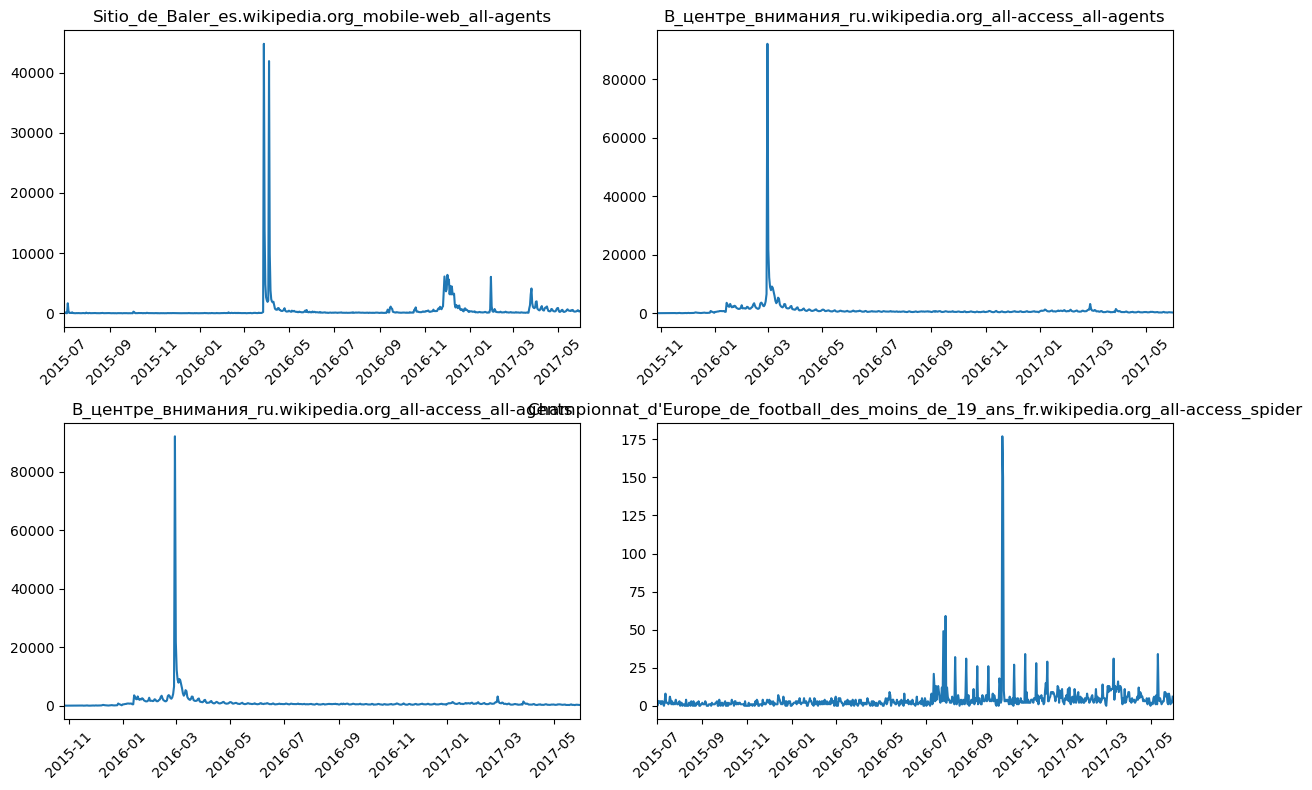

In [202]:
# Look at the viewership of a few articles 
n = 4
indices = np.random.choice(train.index,n)
fig, axs = plt.subplots(2,2,figsize=(12,8))
for i in range(2):
    for j in range(2):
        tmp = train.iloc[indices[i+j],1:]
        axs[i,j].plot(train.iloc[indices[i+j],1:])
        axs[i,j].margins(x=0)
        for tick in axs[i,j].get_xticklabels():
            tick.set_rotation(45)
        axs[i,j].set_title(train.iloc[indices[i+j],0])
plt.tight_layout()
plt.show();

From the above we can see every article has their own distribution and many articles have periods of high viewership (potentially outliers). Given the difference in viewership among all the articles, we will likely have to normalize our data before training it into a model.

Next we look at total daily viewership.

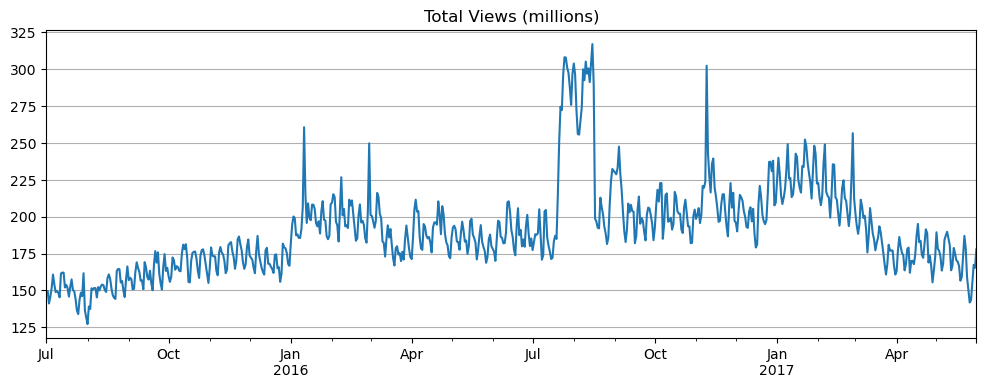

In [203]:
total_daily_views = train.sum(numeric_only=True)
total_daily_views.index = pd.to_datetime(total_daily_views.index)

# Plot 
fig = plt.figure(figsize=(12,4))
ax = plt.gca()
total_daily_views.div(1_000_000).plot(ax=ax)
plt.title('Total Views (millions)')
plt.grid(axis='y')
plt.show();

/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


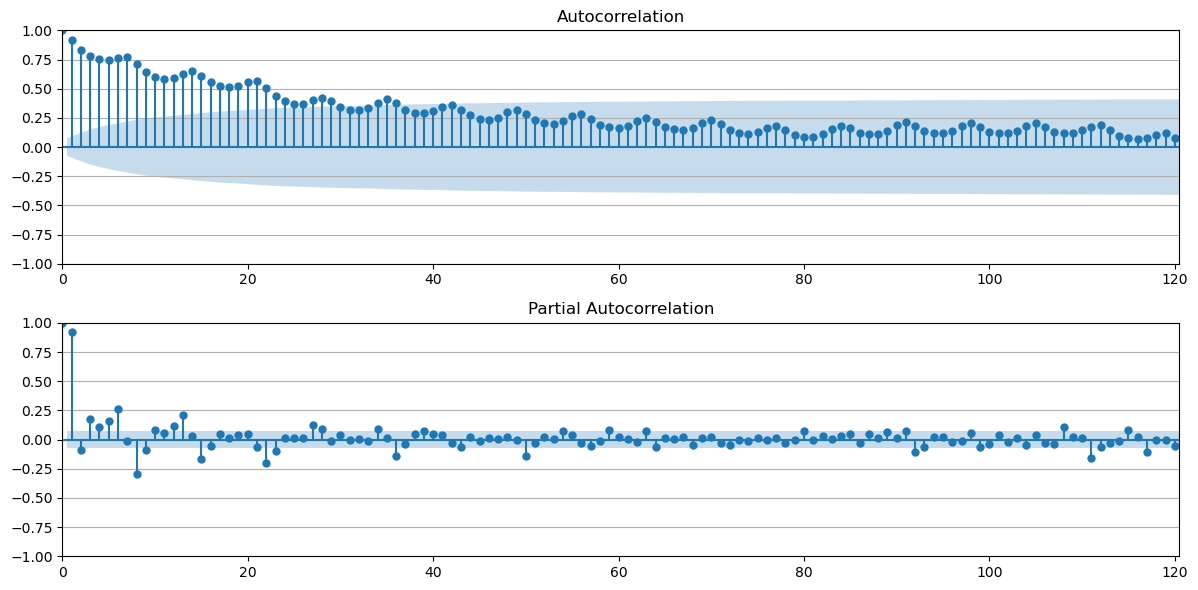

In [204]:
fig, axs = plt.subplots(2,1,figsize=(12,6))
total_daily_views_acf = acf(total_daily_views)
total_daily_views_pacf = pacf(total_daily_views)

axs[0].set_title('ACF')
plot_acf(total_daily_views,lags=120,ax=axs[0]);
axs[0].grid(axis='y')
axs[0].margins(x=0)

axs[1].set_title('PACF')
plot_pacf(total_daily_views,lags=120,ax=axs[1]);
axs[1].grid(axis='y')
axs[1].margins(x=0)

plt.tight_layout()

plt.show();

Notice in the ACF plot we see cyclical pattern every 7 days indicating the day of the week is likely a factor in viewership. When look at the data on a monthly basis, there does not appear to be an effect of it or at least not evident from the autocorrelation or partial autocorrelation charts.

Next we check if we separated our data by language if we'll find any differences in the data

In [3]:
def get_language(url):
    lang = re.search('[a-z][a-z].wikipedia.',url)
    if not lang:
        return 'na'
    else: 
        return lang[0][:2]

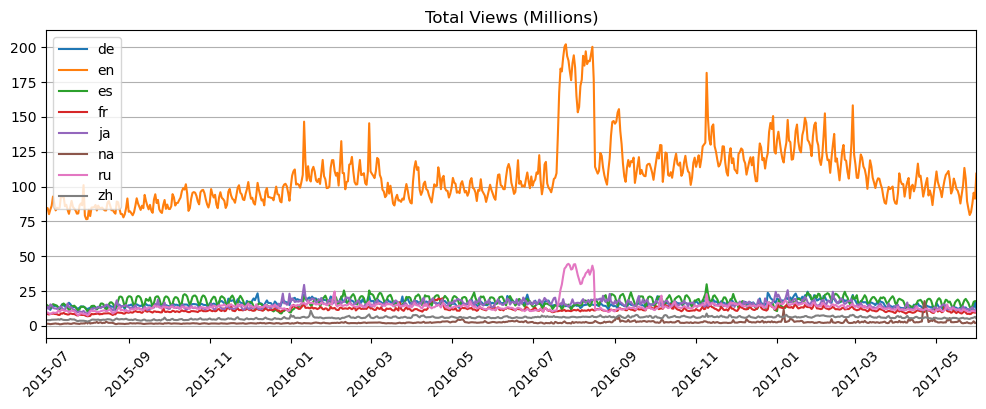

In [206]:
# Get the language of the page 

# Sum the views by language
train['language'] = train['Page'].apply(lambda x: get_language(x))
by_lang = train.groupby('language').sum(numeric_only=True).stack().to_frame()
by_lang = by_lang.div(1_000_000.0)
by_lang.reset_index(inplace=True)
by_lang.columns = ['language','date','views_mill']

# Plot total views by English
fig = plt.figure(figsize=(12,4))
ax = plt.gca()
sns.lineplot(data=by_lang,x='date',y='views_mill',hue='language',ax=ax)

# Labels
plt.title('Total Views (Millions)')
plt.ylabel('')
plt.xlabel('')
plt.legend()

# Aesthetics
plt.grid(axis='y')
plt.xticks(rotation=45)
ax.margins(x=0)

plt.show();

Notice around Aug 2016, we see a spike in viewership in Russian language articles and as well as English articles but not the other languages. This indicates that at times the language of the article may have an effect on viewership. 

Finally given the large number of articles, we are going to look at the total viewership of the top 2000 articles by languages. If these top articles contain most of the viewership then we could likely reduce our training data to a subset of the data. 

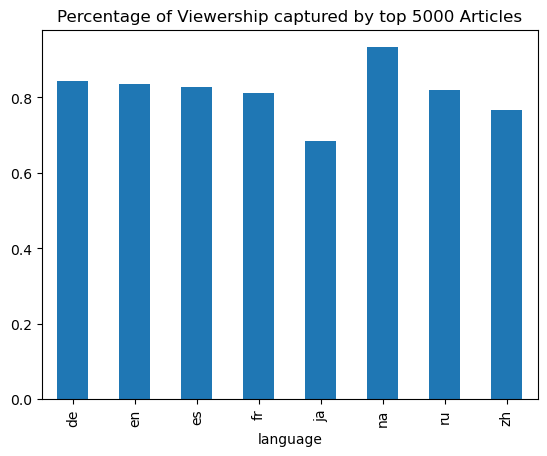

In [208]:
# Find the percentage of viewership the top X articles have 
top = 5000
train['total'] = train.sum(numeric_only=True,axis=1)

total_lang = train.groupby('language').sum(numeric_only=True)['total']

top_n_lang = train.groupby('language',as_index=False).apply(lambda x: x.nlargest(top,'total'))
top_n_lang = top_n_lang.groupby('language').sum(numeric_only=True)['total']
top_n_lang_pct = top_n_lang.div(total_lang)

top_n_lang_pct.plot(kind='bar',title=f'Percentage of Viewership captured by top {top} Articles');

#### Summary of EDA
* Lots of data have missing values and it is unclear whether these should be 0s or actual missing values. As a result, in the training step we will be removing data that have 0s either at the start of the period or at the end of the period. These are more likely the articles which have not been available at the start or end of the training period. 
* Articles appears to have their own distribution of viewership and so should be normalized by the sample first. This will also help retain some information of the data too. 
* The language are features that we can explicitly put into the model. In some cases though, we may want to be minimalistic with our model and let it learn these features on its own
* English articles have the most viewership
* We can use a subset of the data to train our data as over using the top 5000 articles per language has most of the viewership

Based on the above we will begin by creating functions to first preprocess our data and then loading our data into proper formats

In [4]:
INPUT_DAY = 365# NUMBER OF DAYS FOR TRAINING
OUTPUT_DAY = 90# NUMBER OF DAYS TO USE TO CALCULATE THE AVERAGE VIEWERSHIP - OUTPUT
BATCH_SIZE = 32

def create_dataset(dataset,input_n,output_n,top=None,shift=0): 
    '''
    creates the dataset for 
    '''
    data = dataset.copy(deep=True)
    cols = data.columns
    
    # Fill in missing data with 0s 
    data.fillna(0.0, inplace=True)
    
    # Get the top X articles
    data['language'] = data['Page'].map(get_language)
    if top: 
        data['total'] = data.sum(numeric_only=True,axis=1)
        data = data.groupby('language',as_index=False).apply(lambda x: x.nlargest(top,'total'))
        data = data.loc[:,cols]

    # Subset the X and create the response
    # We will take the latest 
    X = data.iloc[:,1:].values[:,-input_n-output_n-shift:-output_n-shift]
    y = data.iloc[:,1:].values[:,-output_n-shift:-shift-1].mean(axis=1)
    
    # Convert the data into a tensor dataset
#     data_tf = tf.data.Dataset.from_tensor_slices((X, y))
    
    # return the dataset 
    return X,y

In [5]:
# Create the dataset
X_test, y_test = create_dataset(data,INPUT_DAY,OUTPUT_DAY,top=5000)
X_val, y_val = create_dataset(data,INPUT_DAY,OUTPUT_DAY,top=5000,shift=OUTPUT_DAY*1)
X_train, y_train = create_dataset(data,INPUT_DAY,OUTPUT_DAY,top=5000,shift=OUTPUT_DAY*2)

# Model Architecture

We take a different approach to modeling the data. First noticed that we had certain features about the data. We first encoded our data ourselves into features. Then we model the features and make predictions of the features. After we add back the mean and std of the data.

In [6]:
def compile_and_fit(X_train,y_train,model,X_val=None,y_val=None,patience=2,learning_rate=1e-4):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min'
    )

    model.compile(
        loss=tf.keras.losses.MeanAbsoluteError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )

    history = model.fit(
        X_train,
        y_train,
        epochs=10, 
        validation_data = (X_val,y_val),
        callbacks=[early_stopping],
        batch_size=32
    )
    
    return history

def plot_history(history,name,title):
    plt.figure(figsize=(12,3))
    plt.title(title)
    plt.plot(range(len(history.history[name])), history.history[name],label='Train')
    plt.plot(range(len(history.history[name])), history.history['val_'+name],label='Validation')
    
    plt.legend()
    plt.xlabel('Epoch')

#### Baseline Model

We are going to create a base model which estimates the mean visitors over the next 90 days as the average over the last year. This was chosen as the base model as it is intuitive and the easiest model for anyone to implement without much knowledge. As a result we are going to compare our result to this model.

In [7]:
test_score = dict()
val_score = dict()
train_score = dict() 

In [8]:
train_score['base'] = mean_absolute_error(X_train.mean(1),y_train)
val_score['base'] = mean_absolute_error(X_val.mean(1),y_val)
test_score['base'] = mean_absolute_error(X_test.mean(1),y_test)

#### Model 1 - CNN

Although CNN models have not typically been used for time series analysis, there has been applications such as in stock market predictions. Hence we explore this alternative method.

In [16]:
def get_cnn_model_0():
    
    model = Sequential()
    model.add(Input(shape = (X_train.shape[1],1,)))
    model.add(Conv1D(32,1,activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(64,1,activation='relu'))
    model.add(BatchNormalization())    
    
    model.add(Dense(64,activation='relu'))
    model.add(Flatten())
    model.add(Dense(1))
    
    return model

with tf.device('/GPU:0'):
    cnn_model_0 = get_cnn_model_0()
    history = compile_and_fit(X_train,y_train,model=cnn_model_0,X_val=X_val,y_val=y_val)

Epoch 1/10
1250/1250 [==============================] - 10s 6ms/step - loss: 3456.1672 - mean_absolute_error: 3456.1672 - val_loss: 3519.5181 - val_mean_absolute_error: 3519.5181
Epoch 2/10
1250/1250 [==============================] - 8s 6ms/step - loss: 3129.9263 - mean_absolute_error: 3129.9263 - val_loss: 3529.9763 - val_mean_absolute_error: 3529.9763
Epoch 3/10
1250/1250 [==============================] - 8s 6ms/step - loss: 3083.9250 - mean_absolute_error: 3083.9250 - val_loss: 3491.0876 - val_mean_absolute_error: 3491.0876
Epoch 4/10
1250/1250 [==============================] - 7s 6ms/step - loss: 3055.9395 - mean_absolute_error: 3055.9395 - val_loss: 2961.0601 - val_mean_absolute_error: 2961.0601
Epoch 5/10
1250/1250 [==============================] - 7s 6ms/step - loss: 3036.6067 - mean_absolute_error: 3036.6067 - val_loss: 3444.7361 - val_mean_absolute_error: 3444.7361
Epoch 6/10
1250/1250 [==============================] - 8s 6ms/step - loss: 3012.7222 - mean_absolute_error: 

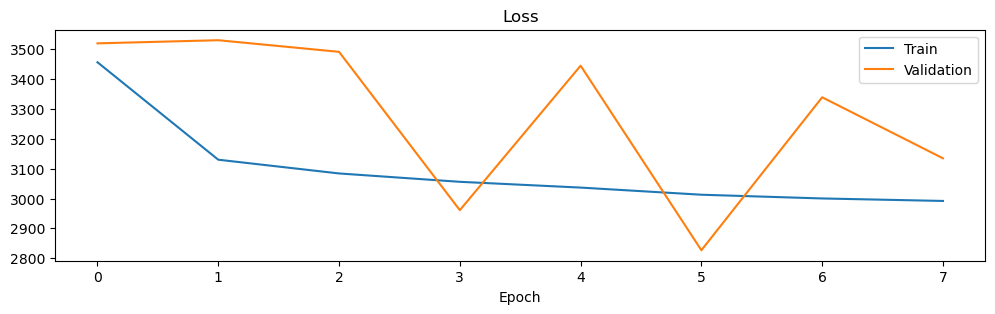

In [17]:
plot_history(history,'loss',title='Loss')

From the above loss chart, we can see there is much improvement to be done. Not only is the loss high, the jump in validation is an indication our learning rate may be too high. 

In [19]:
# Save the test score
prediction = cnn_model_0.predict(X_test)
test_score['cnn-initial'] = mean_absolute_error(prediction,y_test)

1250/1250 [==============================] - 2s 2ms/step


In [22]:
def get_cnn_model_1():
    
    model = Sequential()
    model.add(Input(shape = (X_train.shape[1],1,)))
    model.add(Conv1D(32,1,activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(64,1,activation='relu'))
    model.add(BatchNormalization())    
    
    model.add(Dense(64,activation='relu'))
    model.add(Flatten())
    model.add(Dense(1))
    
    return model

with tf.device('/GPU:0'):
    cnn_model_1 = get_cnn_model_1()
    history_01 = compile_and_fit(X_train,y_train,model=cnn_model_1,X_val=X_val,y_val=y_val,learning_rate=1e-5)

Epoch 1/10
1250/1250 [==============================] - 10s 6ms/step - loss: 4280.5278 - mean_absolute_error: 4280.5278 - val_loss: 3417.6260 - val_mean_absolute_error: 3417.6260
Epoch 2/10
1250/1250 [==============================] - 7s 6ms/step - loss: 4059.9175 - mean_absolute_error: 4059.9175 - val_loss: 3131.8882 - val_mean_absolute_error: 3131.8882
Epoch 3/10
1250/1250 [==============================] - 8s 6ms/step - loss: 3758.2844 - mean_absolute_error: 3758.2844 - val_loss: 2746.4050 - val_mean_absolute_error: 2746.4050
Epoch 4/10
1250/1250 [==============================] - 8s 6ms/step - loss: 3461.0415 - mean_absolute_error: 3461.0415 - val_loss: 2732.9917 - val_mean_absolute_error: 2732.9917
Epoch 5/10
1250/1250 [==============================] - 7s 6ms/step - loss: 3294.8079 - mean_absolute_error: 3294.8079 - val_loss: 2494.7805 - val_mean_absolute_error: 2494.7805
Epoch 6/10
1250/1250 [==============================] - 7s 6ms/step - loss: 3240.2051 - mean_absolute_error: 

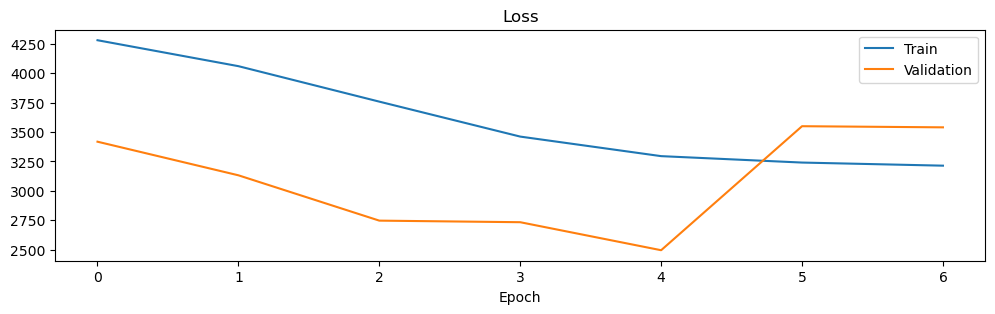

In [23]:
plot_history(history_01,'loss',title='Loss')

From the chart above we can see we begin to over fit after the 4th epoch. The new learning rate though shows approximately a 10% improvement in the loss. Given the high loss still, likely we need to increase the sophistication of our mode. 

In [61]:
def get_cnn_model_3():
    
    model = Sequential()
    model.add(Input(shape = (X_train.shape[1],1,)))
    model.add(BatchNormalization())
    model.add(Conv1D(256,3,activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(64,3,activation='relu'))
    model.add(BatchNormalization())     
    
    model.add(Dense(64,activation='relu'))
    model.add(Flatten())
    model.add(Dense(1))
    
    return model

with tf.device('/GPU:0'):
    cnn_model_3 = get_cnn_model_3()
    history_03 = compile_and_fit(X_train,y_train,model=cnn_model_3,X_val=X_val,y_val=y_val,learning_rate=1e-5,patience=3)

Epoch 1/10
1250/1250 [==============================] - 12s 7ms/step - loss: 4209.3262 - mean_absolute_error: 4209.3262 - val_loss: 3129.3931 - val_mean_absolute_error: 3129.3931
Epoch 2/10
1250/1250 [==============================] - 9s 7ms/step - loss: 3794.1072 - mean_absolute_error: 3794.1072 - val_loss: 3051.7068 - val_mean_absolute_error: 3051.7068
Epoch 3/10
1250/1250 [==============================] - 9s 7ms/step - loss: 3437.8201 - mean_absolute_error: 3437.8201 - val_loss: 2828.9221 - val_mean_absolute_error: 2828.9221
Epoch 4/10
1250/1250 [==============================] - 9s 7ms/step - loss: 3255.7043 - mean_absolute_error: 3255.7043 - val_loss: 2995.5073 - val_mean_absolute_error: 2995.5073
Epoch 5/10
1250/1250 [==============================] - 9s 7ms/step - loss: 3181.0481 - mean_absolute_error: 3181.0481 - val_loss: 2940.8105 - val_mean_absolute_error: 2940.8105
Epoch 6/10
1250/1250 [==============================] - 9s 7ms/step - loss: 3152.0215 - mean_absolute_error: 

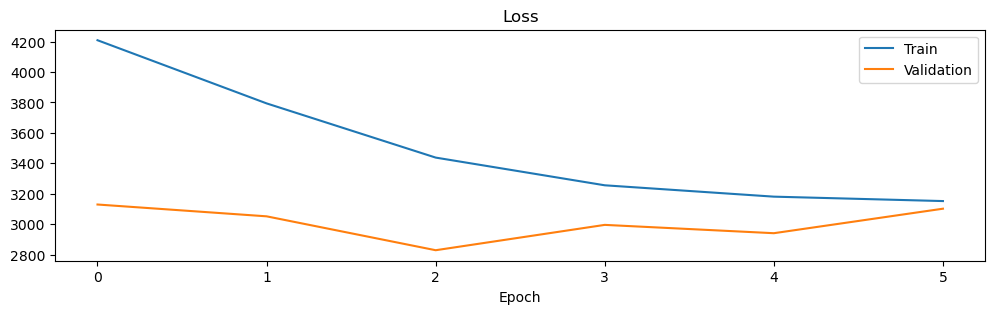

In [62]:
plot_history(history_03,'loss',title='Loss')

In [63]:
# Save the test score
prediction = cnn_model_3.predict(X_test)
test_score['cnn-final'] = mean_absolute_error(prediction,y_test)

1250/1250 [==============================] - 2s 2ms/step


# Results and Analysis

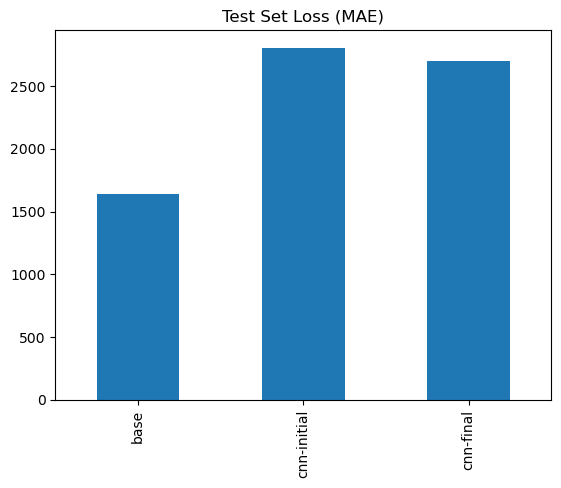

In [64]:
# Show the MAE statistics 
pd.Series(test_score).plot(kind='bar');
plt.title('Test Set Loss (MAE)');

In [55]:
test_score

{'base': 1639.5894775211636,
 'cnn-initial': 2804.894501753492,
 'cnn-final': 2590.9384545797802}

Based on our final conclusion, we can see that our CNN approach to a time series problem still needs improvement as the base model still outperforms the CNN model significantly, by about 40%. A few things we did learn from the hyperparameter tuning though: 
* Increasing the depth of the layer tend to have just lead to overfitting
* Decreasing the learning rate helped up to a certain point
* Adding a LSTM layer cause the exploding/vanishing gradient issue and made training time exponentially longer. Despite LSTM model being better at preventing the exploding/vanishing gradient issue, it is possible and so other methods to help alleviate this has to be considered such as gradient clipping
* Not having a large number of sample points will mean base models based on intuition are likely to outperform deep learning models



# Conclusion

Although we managed to make improvements in our loss function from the initial model to the final model, much improvement is still needed for a successful CNN model on this time series. The base model outperformed the final CNN model by about 40% still and increasing complexity of the CNN architecture appeared to have only made performance worst. 

In future studies, there are many things that can be explored to further explore this area. For one, using more of the training data may potentially add help improve the model. As well finding some encoder to extract features from the data or even explicitly providing features such as the day of the week could be explored to improve the model. Nonetheless though, the improvement shows it is possible for CNN to be applied to web traffic forecasting. 

# References
* https://www.tensorflow.org/tutorials/structured_data/time_series#setup
* https://www.sciencedirect.com/science/article/pii/S0957417419301915